# CNN Polyp Classification

Team 13: James Medel, Sparsha Ramakrishna, Shreya Hunur, Jay Bharadva, Priyank Jagad

May 12, 2022

In [1]:
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import load_model
from keras.metrics import Precision, Recall
from tensorflow_addons.metrics import F1Score
from keras import datasets, layers, models, metrics, backend as K
import h5py
from tensorflow.keras import __version__ as keras_version
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Activation, Lambda, Cropping2D, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import GlobalMaxPooling2D

In [2]:
import os
import csv
import cv2
import sys
import glob
import random
import collections
import pandas as pd
import itertools
import numpy as np
import seaborn as sns
from tqdm import tqdm

from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn import model_selection

import xml.etree.ElementTree as ET

In [3]:
def get_filepaths(basepath, remove_ext=False):
    files = []
    filenames = []
    for filename in os.listdir(basepath):
#         print("filename =", filename)
        if remove_ext is True:
            file_name, file_ext = filename.split(".")
#             print("file_name =", file_name)
#             print("file_ext =", file_ext)
            filepath = os.path.join(basepath, file_name)
            files.append(filepath)
            filenames.append(file_name)
        else:
            filepath = os.path.join(basepath, filename)
            files.append(filepath)
            filenames.append(filename)
    return files, filenames

In [4]:
def get_filepaths_videonum_dirs_xy(X_basepath, y_basepath):
    videonum_X_filepaths = []
    videonum_X_filenames = []
    videonum_y_filepaths = []
    videonum_y_filenames = []
    for videonum_X_dir, videonum_y_dir in zip(os.listdir(X_basepath), os.listdir(y_basepath)):
        videonum_X_dirpath = os.path.join(X_basepath, videonum_X_dir)
        videonum_y_dirpath = os.path.join(y_basepath, videonum_y_dir)
        videonum_y_dirfilepaths_tmp = []
        videonum_y_dirfilenames_tmp = []
        videonum_X_dirfilepaths, videonum_X_dirfilenames = get_filepaths(videonum_X_dirpath, remove_ext=True)
        videonum_y_dirfilepaths, videonum_y_dirfilenames = get_filepaths(videonum_y_dirpath, remove_ext=True)
#         print("len(videonum_X_dirfilenames) =", len(videonum_X_dirfilenames))
#         print("len(videonum_y_dirfilenames) =", len(videonum_y_dirfilenames))
        if len(videonum_X_dirfilenames) != len(videonum_y_dirfilenames):
            for y_i in range(len(videonum_y_dirfilenames)):
                if videonum_y_dirfilenames[y_i] in videonum_X_dirfilenames:
#                     print("videonum_y_dirfilenames[y_i] =", videonum_y_dirfilenames[y_i])
#                     print("is in videonum_X_dirfilenames = ", videonum_X_dirfilenames)
                    videonum_y_dirfilenames_tmp.append(videonum_y_dirfilenames[y_i] + ".xml")
                    videonum_y_dirfilepaths_tmp.append(videonum_y_dirfilepaths[y_i] + ".xml")
            videonum_y_filepaths.extend(videonum_y_dirfilepaths_tmp)
            videonum_y_filenames.extend(videonum_y_dirfilenames_tmp)
#             print("len(videonum_X_dirfilenames) =", len(videonum_X_dirfilenames))
#             print("len(videonum_y_dirfilenames_tmp) =", len(videonum_y_dirfilenames_tmp))
        else:
            videonum_y_dirfilepaths = [filepath + ".xml" for filepath in videonum_y_dirfilepaths]
            videonum_y_dirfilenames = [filename + ".xml" for filename in videonum_y_dirfilenames]
            videonum_y_filepaths.extend(videonum_y_dirfilepaths)
            videonum_y_filenames.extend(videonum_y_dirfilenames)
#             print("len(videonum_X_dirfilenames) =", len(videonum_X_dirfilenames))
#             print("len(videonum_y_dirfilenames) =", len(videonum_y_dirfilenames))
        videonum_X_dirfilepaths = [filepath + ".jpg" for filepath in videonum_X_dirfilepaths]
        videonum_X_dirfilenames = [filename + ".jpg" for filename in videonum_X_dirfilenames]
        videonum_X_filepaths.extend(videonum_X_dirfilepaths)
        videonum_X_filenames.extend(videonum_X_dirfilenames)
    return videonum_X_filepaths, videonum_X_filenames, videonum_y_filepaths, videonum_y_filenames

In [5]:
def read_img(img_path, flag = cv2.IMREAD_COLOR):
    # (height, width, 3)
    image = cv2.imread(img_path, flag)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


In [6]:
def get_xml_label_names(xml_files):
    label_names = []
    for xml_file in tqdm(xml_files):
        train_y_tree = ET.parse(xml_file)
        train_y_root = train_y_tree.getroot()
        if train_y_root.find("object") != None:
            train_y_object = train_y_root.find("object")
            train_y_polyp_name = train_y_object.find("name").text
        else:
            train_y_polyp_name = "Not Specified"
        label_names.append(train_y_polyp_name)
    return label_names

def get_xml_boundboxes(xml_files):
    bound_boxes = []
    for xml_file in tqdm(xml_files):
        train_y_tree = ET.parse(xml_file)
        train_y_root = train_y_tree.getroot()
        if train_y_root.find("object") != None:
            train_y_object = train_y_root.find("object")
            train_y_bndbox = train_y_object.find("bndbox")
            train_y_bndbox_xmin = train_y_bndbox.find("xmin").text
            train_y_bndbox_ymin = train_y_bndbox.find("ymin").text
            train_y_bndbox_xmax = train_y_bndbox.find("xmax").text
            train_y_bndbox_ymax = train_y_bndbox.find("ymax").text
            bound_box_tuple = (train_y_bndbox_xmin, train_y_bndbox_ymin, train_y_bndbox_xmax, train_y_bndbox_ymax)
        else:
            bound_box_tuple = False
        bound_boxes.append(
            bound_box_tuple
        )
    return bound_boxes

In [7]:
def resize_image(image, size):
    resized_image = cv2.resize(image, (size, size))
    return resize_image

def get_images(image_group, size, flag = cv2.IMREAD_COLOR):
    images = []
    for image_path in tqdm(image_group):
        image = read_img(image_path, flag)
        resized_img = cv2.resize(image, (size, size))
        images.append(resized_img)
    return images

def remove_non_labeled_polyps(img_filepaths, img_filenames, polyp_names):
    cln_X_img_filepaths = []
    cln_X_img_filenames = []
    cln_y_polyp_names = []
    for img_filepath, img_filename, label in zip(img_filepaths, img_filenames, polyp_names):
        if label != "Not Specified":
            cln_X_img_filepaths.append(img_filepath)
            cln_X_img_filenames.append(img_filename)
            cln_y_polyp_names.append(label)
            
    return cln_X_img_filepaths, cln_X_img_filenames, cln_y_polyp_names

In [8]:
def get_txt_label_names(txt_files):
    label_names = []
    for txt_file in tqdm(txt_files):
        file = open(txt_file, 'r+')
        polyp_name = file.readline()
        label_names.append(polyp_name)
        file.close()

    return label_names

In [9]:
# The following functions, I referenced from this stackoverflow:
# https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
def recall(y_true, y_pred):
    print("recall: calculating true_positives")
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    print("calculating possible_positives")
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    print("precision: calculating true_positives")
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    print("calculating predicted_positives")
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    print("f1_score: calculating recall")
    recall_m = recall(y_true, y_pred)
    precision_m = precision(y_true, y_pred)
    f1_score_m = 2*((recall_m*precision_m)/(recall_m+precision_m+K.epsilon()))
    return f1_score_m

In [10]:
def plot_sample(X, y, y_pred, index, src_title="Polyp Classification", save_img=True, save_dst=None):
    plt.figure(figsize = (4,4))
    plt.title(src_title, fontsize=20)
    plt.imshow(X[index])
#     plt.xlabel("Actual: {}\nPred: {}".format(
#         classes[y[index]], classes[y_pred[index]]),
#         fontsize=16)
    height = X[index].shape[0]
    width = X[index].shape[1]
    plt.text(width/10, height + 8.5,
        "Actual: {}\nPred: {}".format(
        classes[y[index]], classes[y_pred[index]]),
        va='top',
        fontsize=16)
    plt.axis("off")
    
    if save_img is True:
        if save_dst is not None:
            if not os.path.exists(save_dst):
                os.makedirs(save_dst)
            plt.savefig("{}/pred_polyp_{}_{}.jpg".format(
                save_dst, classes[y_pred[index]], index
            ), bbox_inches="tight")
        else:
            print("Not saving image; no save dst")

In [11]:
# google colab specific
# %cd ..

In [ ]:
# !ls

In [ ]:
# drive.mount('content/gdrive')

In [ ]:
# !ln -s /content/gdrive/My\ Drive/ /mydrive

In [ ]:
# !ls /mydrive

In [ ]:
# !ls /mydrive/PolypsSet/

## Loading Training Images & Labels

We will load about half of the 28.7K+ training images, then perform data augmentation on them.

In [11]:
train_y_basepath = "PolypsSet/train2019/Annotation"
file_type = ".xml"
train_y_filepaths, train_y_filenames = get_filepaths(train_y_basepath, file_type)

In [12]:
train_X_basepath = "PolypsSet/train2019/Image"
file_type = ".jpg"
train_X_filepaths, train_X_filenames = get_filepaths(train_X_basepath, file_type)

In [13]:
# 16000 labels taken from 28.7K+ labels
train_y_polyp_names = get_xml_label_names(train_y_filepaths[:16000])

100%|███████████████████████████████████████████████████████████████████████████| 16000/16000 [01:01<00:00, 260.94it/s]


In [14]:
# For valid & test, there are more labels than imgs, so cleaning
cln_train_X_filepaths, cln_train_X_filenames, cln_train_y_polyp_names = remove_non_labeled_polyps(
    train_X_filepaths[:16000], train_X_filenames[:16000], train_y_polyp_names)

In [15]:
# after cleaning, 14,111 training images read
train_X_images = get_images(cln_train_X_filepaths, 128)

100%|███████████████████████████████████████████████████████████████████████████| 15057/15057 [01:54<00:00, 132.02it/s]


In [ ]:
# ignore for now since we'll do this on augmented data
# X_train = np.array(train_X_images)
# X_train = X_train / 255
# label_enc = LabelEncoder()
# train_y = label_enc.fit_transform(cln_train_y_polyp_names)
# classes = ['adenomatous', 'hyperplastic']

In [16]:
import albumentations as A

In [17]:
# augment 28,000 images out of the sample of 15,057 images
images_to_generate = 28000

In [18]:
img_aug_train_path="PolypsSet/train2019/aug_train/aug_img_128_clf/"
label_aug_train_path="PolypsSet/train2019/aug_train/aug_label_128_clf/" # path to gray seg masks

img_aug_test_path="PolypsSet/train2019/aug_test/aug_img_128_clf/"
label_aug_test_path="PolypsSet/train2019/aug_test/aug_label_128_clf/" # path to gray seg masks

In [19]:
aug = A.Compose([
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=1),
    A.Transpose(p=1),
    A.GridDistortion(p=1)
])

In [20]:
i=1
# augmenting on top of 15,057 images and 15,057 polyp name labels to gen 28,000 images and labels
# then save them in a folder
polyp_type_train_count = []
polyp_type_test_count = []
while i <= images_to_generate:
    # this random number from indices 0 to 14,111 for polyp images
    number = random.randint(0, len(train_X_images)-1)
    orig_image = train_X_images[number]
    orig_label = cln_train_y_polyp_names[number]
    
    augmented = aug(image = orig_image)
    transformed_image = augmented["image"]
    transformed_label = orig_label
    
    if not os.path.exists(img_aug_train_path):
        os.makedirs(img_aug_train_path)
    
    if not os.path.exists(label_aug_train_path):
        os.makedirs(label_aug_train_path)
    
    if not os.path.exists(img_aug_test_path):
        os.makedirs(img_aug_test_path)
    
    if not os.path.exists(label_aug_test_path):
        os.makedirs(label_aug_test_path)
    
    # put 80% of aug images in augmented training folder: 19,200 imgs
    if i <= images_to_generate*0.8:
        new_image_path = "%s/aug_image_%s.jpg" %(img_aug_train_path, i)
        new_label_path = "%s/aug_label_%s.txt" %(label_aug_train_path, i)
        polyp_type_train_count.append(transformed_label)
    else:
        new_image_path = "%s/aug_image_%s.jpg" %(img_aug_test_path, i)
        new_label_path = "%s/aug_label_%s.txt" %(label_aug_test_path, i)
        polyp_type_test_count.append(transformed_label)
    
    plt.imsave(new_image_path, transformed_image)
    file = open(new_label_path, "w")
    file.write(transformed_label)
    file.close()
    i = i+1


C:\Users\james\miniconda3\envs\rasa-tf-gpu\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Count Polyp Types for Aug Training')

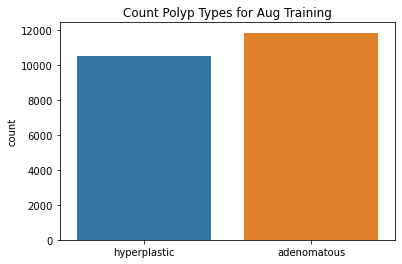

In [21]:
sns.countplot(polyp_type_train_count)
plt.title("Count Polyp Types for Aug Training")

C:\Users\james\miniconda3\envs\rasa-tf-gpu\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Count Polyp Types for Aug Testing')

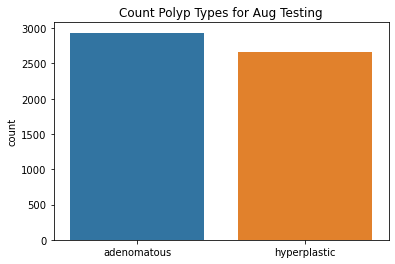

In [22]:
sns.countplot(polyp_type_test_count)
plt.title("Count Polyp Types for Aug Testing")

## Load Augmented Polyp Training Set

In [11]:
aug_train_X_basepath = "PolypsSet/train2019/aug_train/aug_img_128_clf/"
file_type = ".jpg"
aug_train_X_filepaths, aug_train_X_filenames = get_filepaths(aug_train_X_basepath, file_type)

In [12]:
aug_train_X_images = get_images(aug_train_X_filepaths, 128)

100%|██████████████████████████████████████████████████████████████████████████| 22400/22400 [00:14<00:00, 1543.49it/s]


In [13]:
aug_X_train = np.array(aug_train_X_images)

In [14]:
aug_X_train = aug_X_train / 255

In [15]:
aug_train_label_basepath = "PolypsSet/train2019/aug_train/aug_label_128_clf/"
file_type = ".txt"
aug_train_label_filepaths, aug_train_label_filenames = get_filepaths(aug_train_label_basepath)

In [16]:
aug_y_train = get_txt_label_names(aug_train_label_filepaths)

100%|██████████████████████████████████████████████████████████████████████████| 22400/22400 [00:08<00:00, 2504.01it/s]


In [17]:
label_enc = LabelEncoder()
aug_y_train = label_enc.fit_transform(aug_y_train)
classes = ['adenomatous', 'hyperplastic']

## Load Augmented Polyp Testing Set

In [18]:
aug_test_X_basepath = "PolypsSet/train2019/aug_test/aug_img_128_clf/"
file_type = ".jpg"
aug_test_X_filepaths, aug_test_X_filenames = get_filepaths(aug_test_X_basepath, file_type)
aug_test_X_images = get_images(aug_test_X_filepaths, 128)

100%|████████████████████████████████████████████████████████████████████████████| 5600/5600 [00:03<00:00, 1408.06it/s]


In [19]:
aug_X_test = np.array(aug_test_X_images)
aug_X_test = aug_X_test / 255

In [20]:
aug_test_label_basepath = "PolypsSet/train2019/aug_test/aug_label_128_clf/"
file_type = ".txt"
aug_test_label_filepaths, aug_test_label_filenames = get_filepaths(aug_test_label_basepath)
aug_y_test = get_txt_label_names(aug_test_label_filepaths)

100%|████████████████████████████████████████████████████████████████████████████| 5600/5600 [00:00<00:00, 6602.27it/s]


In [21]:
aug_y_test = label_enc.fit_transform(aug_y_test)

In [22]:
# Not able to allocate storage
# X_train_polyp, X_test_polyp, y_train_polyp, y_test_polyp = model_selection.train_test_split(
#     aug_X_train, train_y, test_size=0.2, random_state=42
# )

## Build & Train CNN Polyp CLF on Augmented Data

In [23]:
cnn = models.Sequential([
    # 2 Convolution layers: first with 32 filters, second with 64 filters
    layers.Conv2D(filters=24, kernel_size=(5,5), activation="relu", input_shape=(128,128,3)),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(filters=32, kernel_size=(5,5), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.5),
    
    layers.Conv2D(filters=48, kernel_size=(5,5), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),
    
    # 2 Dense layers
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

In [24]:
# F1Score num_classes based on binary classification, so 1
cnn.compile(optimizer="adam",
            loss="binary_crossentropy",
            metrics=["accuracy", Precision(), Recall()])

In [25]:
# Training CNN on 22,400 augmented polyp images; 20% for validation
history = cnn.fit(aug_X_train, aug_y_train, validation_split=0.2, epochs=9)

Epoch 1/9
560/560 [==============================] - 25s 29ms/step - loss: 0.6838 - accuracy: 0.5395 - precision: 0.5250 - recall: 0.2057 - val_loss: 0.6648 - val_accuracy: 0.5757 - val_precision: 0.5318 - val_recall: 0.8280
Epoch 2/9
560/560 [==============================] - 8s 15ms/step - loss: 0.6649 - accuracy: 0.5798 - precision: 0.5477 - recall: 0.6053 - val_loss: 0.6500 - val_accuracy: 0.6143 - val_precision: 0.5951 - val_recall: 0.5664
Epoch 3/9
560/560 [==============================] - 8s 14ms/step - loss: 0.6038 - accuracy: 0.6647 - precision: 0.6392 - recall: 0.6571 - val_loss: 0.5565 - val_accuracy: 0.7080 - val_precision: 0.6511 - val_recall: 0.8190
Epoch 4/9
560/560 [==============================] - 8s 14ms/step - loss: 0.5425 - accuracy: 0.7185 - precision: 0.7016 - recall: 0.6973 - val_loss: 0.5010 - val_accuracy: 0.7592 - val_precision: 0.7213 - val_recall: 0.7962
Epoch 5/9
560/560 [==============================] - 8s 14ms/step - loss: 0.4915 - accuracy: 0.7539 - p

## Plot Train vs Valid Loss Curves After Training CNN Classifier

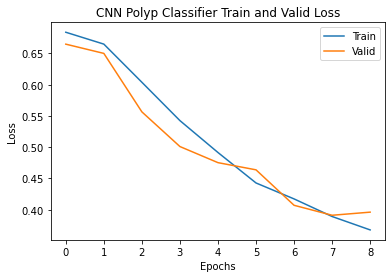

In [26]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("CNN Polyp Classifier Train and Valid Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Valid"], loc="upper right")
plt.show()

## Plot Train vs Valid Accuracy Curves After Training CNN Classifier

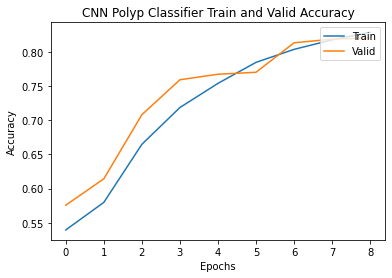

In [27]:
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("CNN Polyp Classifier Train and Valid Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Valid"], loc="upper right")
plt.show()

## Plot Train vs Valid Precision Curves After Training CNN Classifier

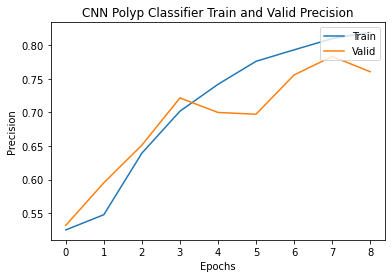

In [28]:
plt.figure()
plt.plot(history.history["precision"])
plt.plot(history.history["val_precision"])
plt.title("CNN Polyp Classifier Train and Valid Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend(["Train", "Valid"], loc="upper right")
plt.show()

## Plot Train vs Valid Recall Curves After Training CNN Classifier

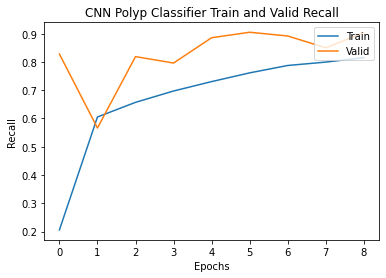

In [29]:
plt.figure()
plt.plot(history.history["recall"])
plt.plot(history.history["val_recall"])
plt.title("CNN Polyp Classifier Train and Valid Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend(["Train", "Valid"], loc="upper right")
plt.show()

## Evaluate CNN on Testing Set

In [30]:
# took 5600 and tested model on that
cnn_eval = cnn.evaluate(aug_X_test,aug_y_test)

175/175 [==============================] - 1s 7ms/step - loss: 0.3886 - accuracy: 0.8196 - precision: 0.7609 - recall: 0.9054


In [31]:
# trained CNN model 28K augmented images each at 128x128
cnn.save('polyp_cnn_clf_28000imgs_128hw.h5')

## Run Predictions

In [32]:
classes = ['adenomatous', 'hyperplastic']

In [23]:
# cnn = load_model("polyp_cnn_clf_28000imgs_128hw.h5")

In [34]:
y_pred = cnn.predict(aug_X_test)

In [35]:
y_pred[:5]

array([[0.07744051],
       [0.9802381 ],
       [0.92509   ],
       [0.62743026],
       [0.96412385]], dtype=float32)

In [36]:
y_pred_classes = [0 if element < 0.5 else 1 for element in y_pred]

C:\Users\james\miniconda3\envs\rasa-tf-gpu\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Count Polyp Type Predictions for Aug Testing')

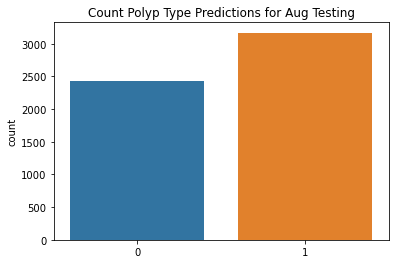

In [37]:
sns.countplot(y_pred_classes)
plt.title("Count Polyp Type Predictions for Aug Testing")

In [38]:
print("Classification Report: \n", classification_report(aug_y_test, y_pred_classes, target_names=classes))

Classification Report: 
               precision    recall  f1-score   support

 adenomatous       0.90      0.74      0.81      2936
hyperplastic       0.76      0.91      0.83      2664

    accuracy                           0.82      5600
   macro avg       0.83      0.82      0.82      5600
weighted avg       0.83      0.82      0.82      5600



In [39]:
y_pred_classes[:5]

[0, 1, 1, 1, 1]

In [40]:
aug_y_test[:5]

array([0, 1, 1, 1, 1], dtype=int64)

Plot the **Actual Polyp Image** being at index 0. Then also show the predicted value just below it. We'll see the **actual label** vs the **predicted label**.

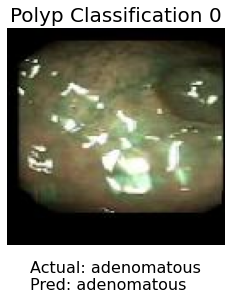

In [41]:
plot_sample(aug_X_test, 
            aug_y_test, y_pred_classes, index=0, 
            src_title="Polyp Classification " + str(0),
            save_img=True,
            save_dst="cnn_clf/trained_14000_aug/clf_pred_images")

From running our Polyp classifier above, we can see it correctly classified the polyp to be **adenomatous**. You'll see for the last 10 predictions, our CNN got **8 out of 10** predictions correct.

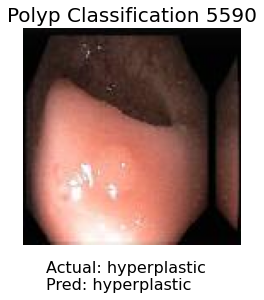

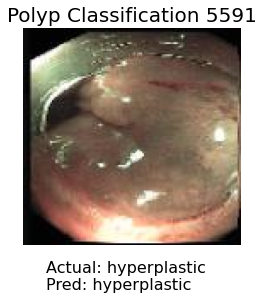

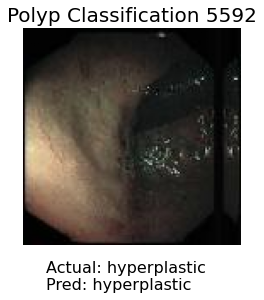

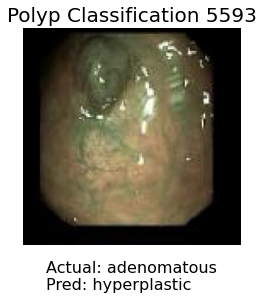

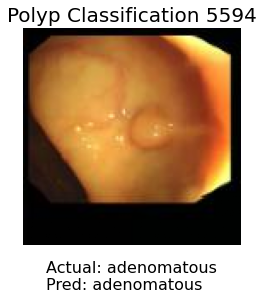

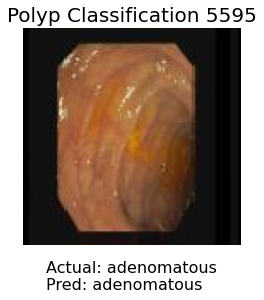

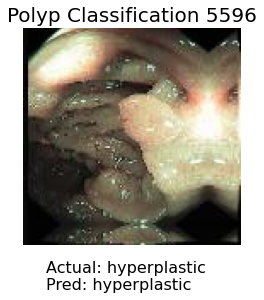

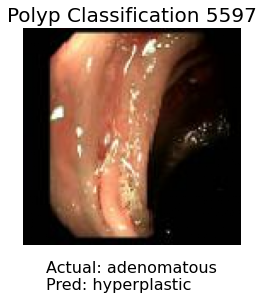

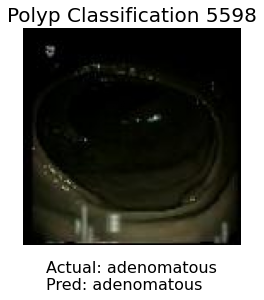

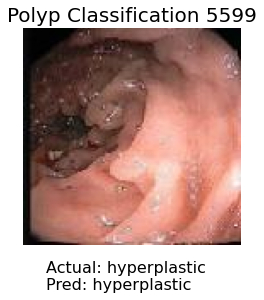

In [42]:
for i in range(len(aug_X_test)-10, len(aug_X_test)):
    plot_sample(aug_X_test, 
                aug_y_test, y_pred_classes, index=i, 
                src_title="Polyp Classification " + str(i),
                save_img=True,
                save_dst="cnn_clf/trained_14000_aug/clf_pred_images")

Next you'll see for the first 10 predictions, our CNN got **9 out of 10** predictions correct.

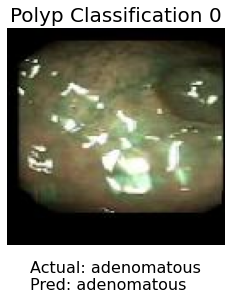

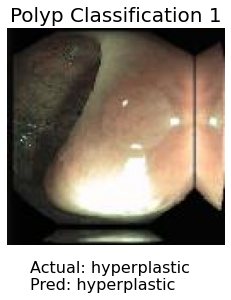

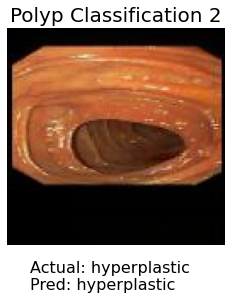

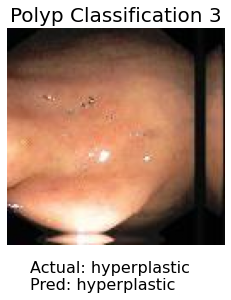

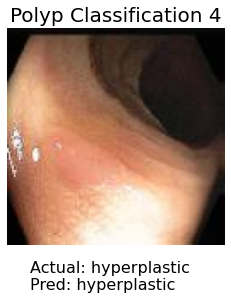

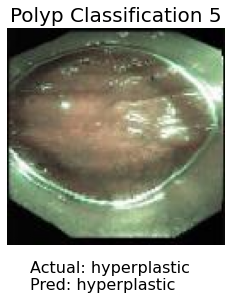

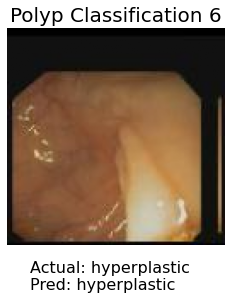

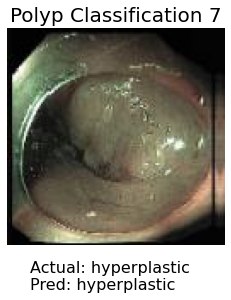

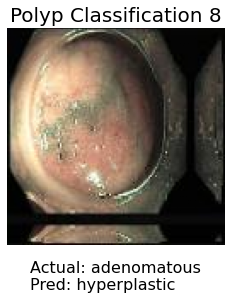

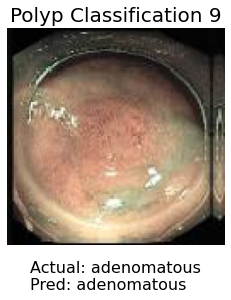

In [43]:
for i in range(0, 10):
    plot_sample(aug_X_test, 
                aug_y_test, y_pred_classes, index=i, 
                src_title="Polyp Classification " + str(i),
                save_img=True,
                save_dst="cnn_clf/trained_14000_aug/clf_pred_images")